In [49]:
import numpy as np 
import pandas as pd 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [50]:
data = pd.read_csv("Dataset .csv")
data.head(2)

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null   object 
 14  Is delivering now     9551 non-null   object 
 15  Switch to order menu 

### Data preprocessing

In [52]:
print("Missing values per column:")
print(data.isnull().sum()) 

Missing values per column:
Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64


In [53]:
data.duplicated().sum()

0

<Axes: xlabel='City'>

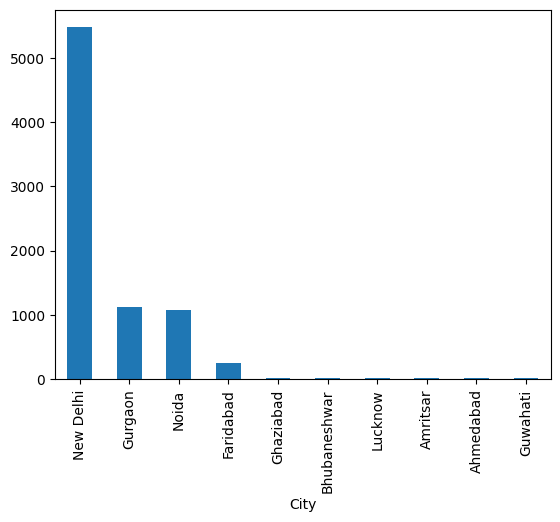

In [54]:
group = data.groupby('City').size()
top_10_cities=group.sort_values(ascending=False).head(10)
top_10_cities.plot.bar()

In [55]:
data_city =data.loc[data['City'] == 'New Delhi']

In [61]:
data_new_delhi=data_city[['Restaurant Name','Cuisines','Locality','Aggregate rating']]

In [62]:
data_new_delhi['Locality'].value_counts(dropna = False).head(5)

Locality
Connaught Place    122
Rajouri Garden      99
Shahdara            87
Defence Colony      86
Pitampura           85
Name: count, dtype: int64

In [63]:
data_new_delhi.loc[data['Locality'] == 'Connaught Place']

,Restaurant Name,Cuisines,Locality,Aggregate rating
2999,Amber,"North Indian, Chinese, Mughlai",Connaught Place,2.6
3000,Attitude Kitchen & Bar,"North Indian, Continental, Italian",Connaught Place,2.9
3001,Cafe Coffee Day,Cafe,Connaught Place,3.4
3002,Castle 9,"Finger Food, Continental, North Indian, Chinese",Connaught Place,3.1
3003,Costa Coffee,Cafe,Connaught Place,3.4
...,...,...,...,...
3116,United Coffee House,"North Indian, European, Asian, Mediterranean",Connaught Place,4.1
3117,Unplugged Courtyard,"North Indian, Continental",Connaught Place,4.0
3118,Wenger's Deli,"Bakery, Desserts, Fast Food",Connaught Place,4.3
3119,Wenger's,"Bakery, Fast Food, Desserts",Connaught Place,4.3


In [75]:
data_sample=[]
def restaurant_recommend_func(location,title,Cuisines):   
    global data_sample       
    global cosine_sim
    global sim_scores
    global tfidf_matrix
    global corpus_index
    global feature
    global rest_indices
    global idx
    
    # When location comes from function ,our new data consist only location dataset
    data_sample = data_new_delhi.loc[data_new_delhi['Locality'] == location]  
    
    # index will be reset for cosine similarty index because Cosine similarty index has to be same value with result of tf-idf vectorize
    data_sample.reset_index(level=0, inplace=True) 
    
    #Feature Extraction
    data_sample['Split']="X"
    for i in range(0,data_sample.index[-1]):
        split_data=re.split(r'[,]', data_sample['Cuisines'][i])
        for k,l in enumerate(split_data):
            split_data[k]=(split_data[k].replace(" ", ""))
        split_data=' '.join(split_data[:])
        data_sample['Split'].iloc[i]=split_data
        
    #TF-IDF vectorizer
    
    tfidf = TfidfVectorizer(stop_words='english')
    data_sample['Split'] = data_sample['Split'].fillna('')
    tfidf_matrix = tfidf.fit_transform(data_sample['Split'])
    tfidf_matrix.shape
    feature= tfidf.vocabulary_
    
    #Cosine Similarity
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) 
    corpus_index=[n for n in data_sample['Split']]  
    indices = pd.Series(data_sample.index, index=data_sample['Restaurant Name']).drop_duplicates() 
    idx = indices[title]
    
    #Aggregate rating added with cosine score in sim_score list.
    sim_scores=[]
    for i,j in enumerate(cosine_sim[idx]):
        k=data_sample['Aggregate rating'].iloc[i]
        if j != 0 :
            sim_scores.append((i,j,k))
            
    #Sort the restaurant names based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: (x[1],x[2]) , reverse=True)# 10 similar cuisines
    sim_scores = sim_scores[0:10]
    rest_indices = [i[0] for i in sim_scores] 
  
    data_x =data_sample[['Restaurant Name','Aggregate rating']].iloc[rest_indices]
    
    data_x['Cosine Similarity']=0
    for i,j in enumerate(sim_scores):
        data_x['Cosine Similarity'].iloc[i]=round(sim_scores[i][1],2)
    recommended_cuisines = [data_sample['Cuisines'].iloc[i] for i in rest_indices]

    # Create DataFrame with recommendations including cuisine
    data_x = data_sample[['Restaurant Name', 'Aggregate rating']].iloc[rest_indices]
    data_x['Cosine Similarity'] = [round(score[1], 2) for score in sim_scores]
    data_x['Cuisine'] = recommended_cuisines
   
    return data_x


In [77]:
# Top 10 similar restaurant with cuisine of 'Pizza Hut' restaurant in Connaught Place
restaurant_recommend_func('Connaught Place','Pizza Hut','Italian')

,Restaurant Name,Aggregate rating,Cosine Similarity,Cuisine
63,Pizza Hut,3.5,1.00,"Italian, Pizza, Fast Food"
32,Domino's Pizza,3.7,0.90,"Pizza, Fast Food"
91,Ovenstory Pizza,0.0,0.90,"Pizza, Fast Food"
70,Sbarro,3.5,0.86,"Pizza, Italian"
26,Caffe Tonino,3.9,0.68,"Pizza, Italian, Cafe"
83,The Rolling Joint,3.9,0.52,Fast Food
8,Indian Coffee House,3.3,0.52,Fast Food
58,Nizam's Kathi Kabab,3.8,0.45,"North Indian, Fast Food"
82,The Luggage Room Kitchen And Bar,3.5,0.36,"North Indian, Continental, Fast Food"
49,Life Caffe,3.6,0.36,"Cafe, North Indian, Italian, Japanese, Fast Food"
